### Subcluster and Monocle3 Pseudotime analysis on Tubules-related clusters

Main Figure 6 and corresponding supplemental figures are generated

Author: Haojia Wu, Pierre Isnard, Dian Li

Contact: dianli@wustl.edu

Last updated: December 12, 2023

In [1]:
suppressMessages(library(Seurat))
suppressMessages(library(ggplot2))
# suppressMessages(library(reshape2))
suppressMessages(library(EnhancedVolcano))
suppressMessages(library(dplyr))

In [2]:
plots_path_main = "../../plots/version_1/main_figures"
plots_path_supp = "../../plots/version_1/supp_figures"
processed_data_path = "../../processed_data/version_1/FindMarkers/"

dir.create(plots_path_main, showWarnings = F, recursive = T)
dir.create(plots_path_supp, showWarnings = F, recursive = T)
dir.create(processed_data_path, showWarnings = F, recursive = T)

In [3]:
tubules_cluster = c("PT", "Inj-T", "LH", "CD", "Cast-T")

### Step 1. Load dkd1 Seurat object and subset tubulo clusters

In [4]:
dkd1 <- Load10X_Spatial(data.dir = "../../data/AJHM365_dkd/outs/")

In [5]:
dkd1

head(dkd1)

An object of class Seurat 
18085 features across 2802 samples within 1 assay 
Active assay: Spatial (18085 features, 0 variable features)
 1 image present: slice1

,orig.ident,nCount_Spatial,nFeature_Spatial
,<fct>,<dbl>,<int>
AACACTTGGCAAGGAA-1,SeuratProject,37726,9197
AACAGGATTCATAGTT-1,SeuratProject,15426,6541
AACAGGTTATTGCACC-1,SeuratProject,19244,7267
AACAGGTTCACCGAAG-1,SeuratProject,24380,8180
AACAGTCAGGCTCCGC-1,SeuratProject,22432,8043
AACATCTTAAGGCTCA-1,SeuratProject,18935,7598
AACCAAGGTATCAGGC-1,SeuratProject,20335,7284
AACCACTGCCATAGCC-1,SeuratProject,19412,7224
AACCAGAATCAGACGT-1,SeuratProject,19358,7376


In [6]:
load("../../meta/meta_info.RData")

In [7]:
color_palette_tubules = color_palette[names(color_palette) %in% tubules_cluster]
color_palette_tubules["CD"] = "#48bfe3"
color_palette_tubules["LH"] = "#90e0ef"

In [8]:
meta_tubules = read.csv("../../meta/Tubules_CD-LH.csv")
dim(meta_tubules)
head(meta_tubules)

[1] 2802    2

,Barcode,Tubules
,<chr>,<chr>
1,AACCAAGGTATCAGGC-1,Cast-T
2,AACCTAAGATACTGAG-1,Cast-T
3,AACGAGCTAATAACTA-1,Cast-T
4,AACTGCGATCGACTAA-1,Cast-T
5,AACTGGTCATGTGGTT-1,Cast-T
6,AACTTGCTCGTAACCG-1,Cast-T


#### Step 1.2. add Tubules meta data to dkd1 object

In [9]:
meta_tmp = dkd1@meta.data
meta_tmp$Barcode = rownames(meta_tmp)
meta_tmp = left_join(meta_tmp, meta_tubules, by = "Barcode")
rownames(meta_tmp) = meta_tmp$Barcode
dkd1@meta.data = meta_tmp

#### Step 1.3. Export subcluster meta for CellScope Visualization

In [10]:
table(meta_tmp$Tubules)
head(meta_tmp)


Cast-T     CD  Inj-T     LH  Other     PT 
   350    396    345    253   1163    295 

,orig.ident,nCount_Spatial,nFeature_Spatial,Barcode,Tubules
,<fct>,<dbl>,<int>,<chr>,<chr>
AACACTTGGCAAGGAA-1,SeuratProject,37726,9197,AACACTTGGCAAGGAA-1,Other
AACAGGATTCATAGTT-1,SeuratProject,15426,6541,AACAGGATTCATAGTT-1,Other
AACAGGTTATTGCACC-1,SeuratProject,19244,7267,AACAGGTTATTGCACC-1,PT
AACAGGTTCACCGAAG-1,SeuratProject,24380,8180,AACAGGTTCACCGAAG-1,CD
AACAGTCAGGCTCCGC-1,SeuratProject,22432,8043,AACAGTCAGGCTCCGC-1,Other
AACATCTTAAGGCTCA-1,SeuratProject,18935,7598,AACATCTTAAGGCTCA-1,Other


In [11]:
df_meta = data.frame("barcode" = meta_tmp$Barcode)
df_meta$tubule_cluster = "none"
rownames(df_meta) = meta_tmp$Barcode

df_meta[meta_tmp$Barcode, "tubule_cluster"] = meta_tmp$Tubules
write.csv(df_meta, "../../meta/subclusters_Tubules.csv", row.names = F)

#### Step 1.4. subset dkd1 object

In [12]:
Idents(dkd1) = "Tubules"
dkd1_tubules = subset(dkd1, idents = tubules_cluster)
dkd1_tubules

An object of class Seurat 
18085 features across 1639 samples within 1 assay 
Active assay: Spatial (18085 features, 0 variable features)
 1 image present: slice1

In [13]:
dkd1_tubules$Tubules = factor(dkd1_tubules$Tubules, levels = tubules_cluster)

table(Idents(dkd1_tubules))


    PT     CD Cast-T  Inj-T     LH 
   295    396    350    345    253 

### Step 2. Generate UMAP for dkd1_tubules

In [14]:
dkd1_tubules <- SCTransform(dkd1_tubules, assay = "Spatial", verbose = FALSE)
dkd1_tubules <- RunPCA(dkd1_tubules, assay = "SCT", verbose = FALSE)
dkd1_tubules <- FindNeighbors(dkd1_tubules, reduction = "pca", dims = 1:20)
dkd1_tubules <- FindClusters(dkd1_tubules, verbose = FALSE, resolution = 0.3)
dkd1_tubules <- RunUMAP(dkd1_tubules, reduction = "pca", dims = 1:20, min.dist = 0.1)

Computing nearest neighbor graph

Computing SNN

Warning message:
“The default method for RunUMAP has changed from calling Python UMAP via reticulate to the R-native UWOT using the cosine metric
To use Python UMAP via reticulate, set umap.method to 'umap-learn' and metric to 'correlation'
This message will be shown once per session”
16:01:04 UMAP embedding parameters a = 1.577 b = 0.8951

16:01:04 Read 1639 rows and found 20 numeric columns

16:01:04 Using Annoy for neighbor search, n_neighbors = 30

16:01:04 Building Annoy index with metric = cosine, n_trees = 50

0%   10   20   30   40   50   60   70   80   90   100%

[----|----|----|----|----|----|----|----|----|----|

*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
|

16:01:04 Writing NN index file to temp file /tmp/RtmpZsDraA/file2c57bc46b079fd

16:01:04 Searching Annoy index using 1 thread, search_k = 3000

16:01:05 Annoy recall = 100%

16:01:05 Commencing smooth kNN distance ca

In [15]:
Idents(dkd1_tubules) = factor(dkd1_tubules$Tubules, levels = tubules_cluster)

In [16]:
custom_theme <- theme(text = element_text(family = "Helvetica", size=20))

empty_theme = theme(
    axis.line.x=element_blank(),
    axis.line.y=element_blank(),
      axis.text.x=element_blank(),
      axis.text.y=element_blank(),
      axis.ticks=element_blank(),
      axis.title.x=element_blank(),
      axis.title.y=element_blank())

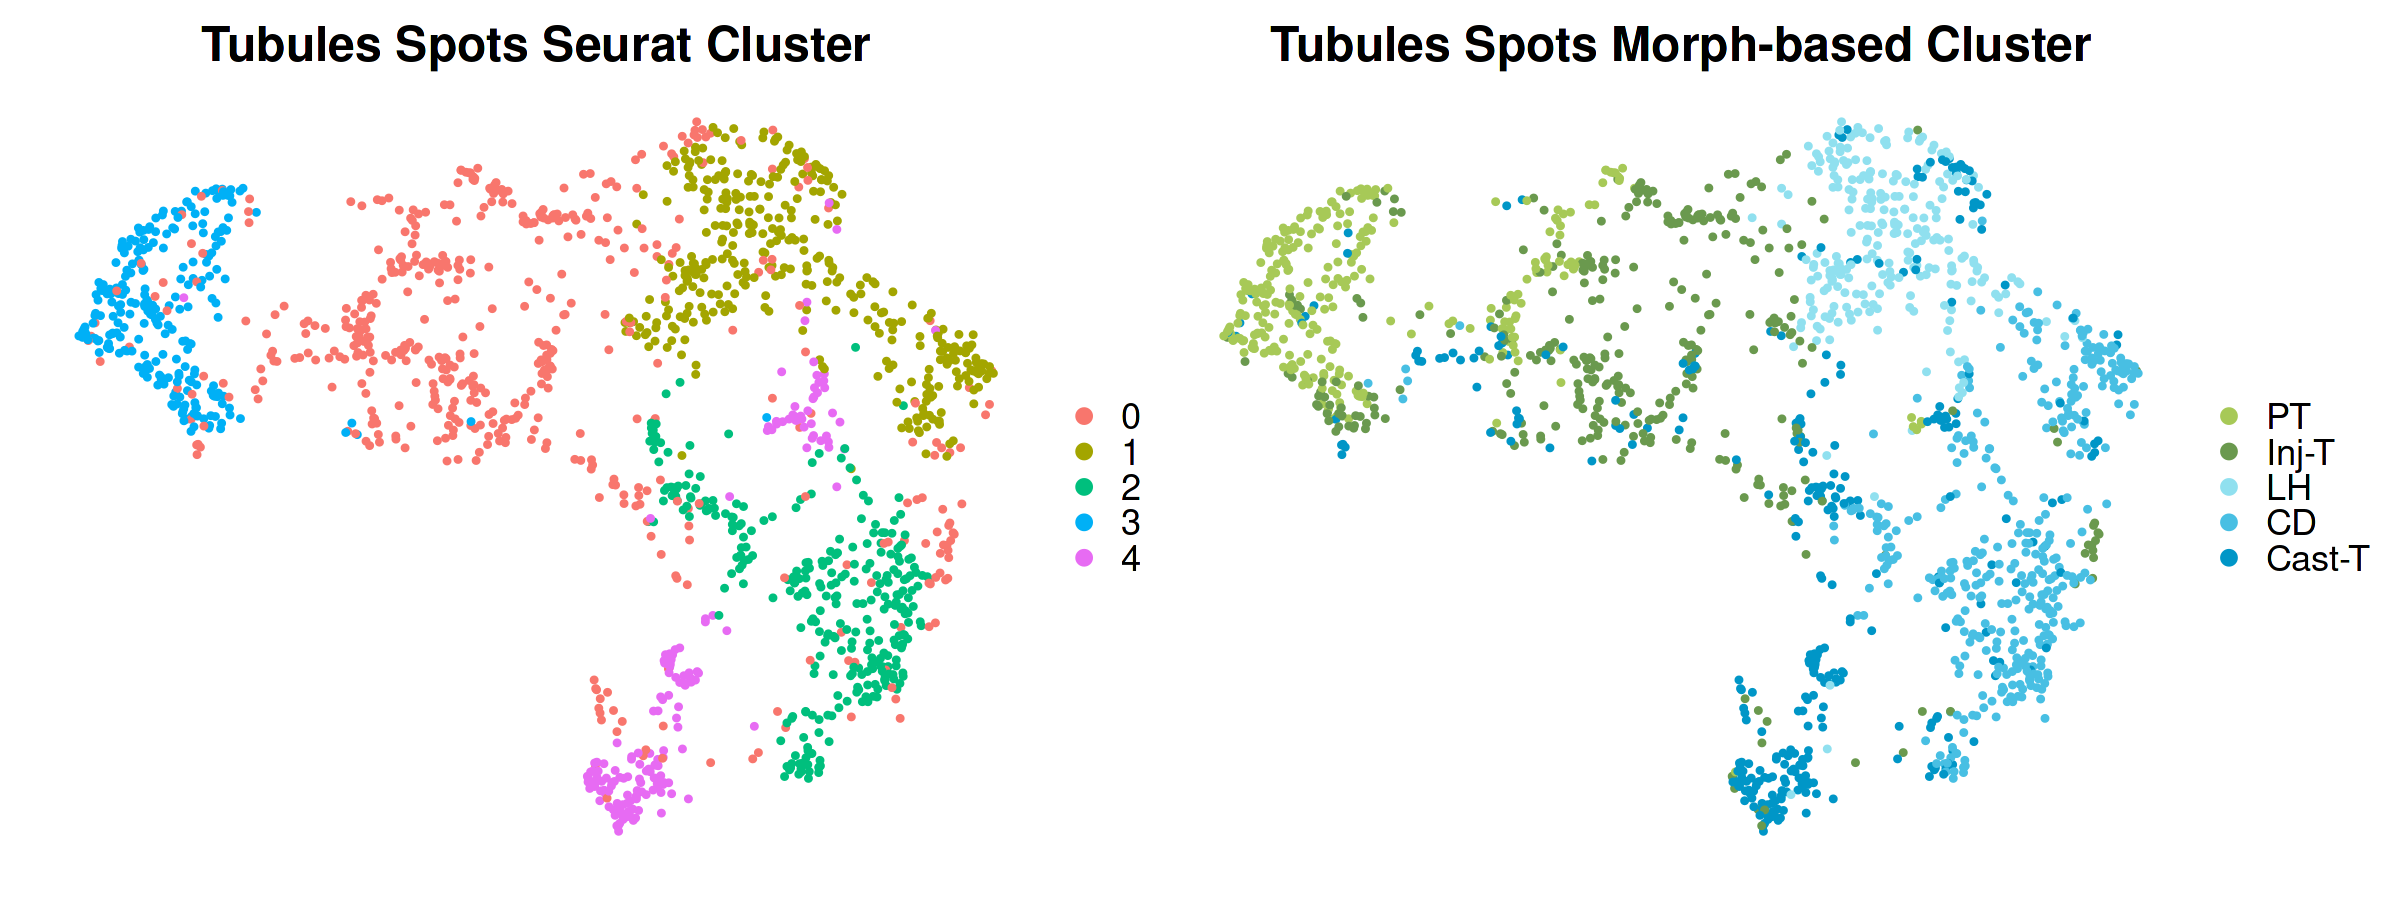

In [17]:
options(repr.plot.width = 16, repr.plot.height = 6, repr.plot.res = 150)
p1 = DimPlot(dkd1_tubules, group.by = "seurat_clusters", 
             raster = FALSE, pt.size = 1) + 
    ggtitle(label = "Tubules Spots Seurat Cluster")
p1 = p1 + empty_theme + custom_theme

p2 = DimPlot(dkd1_tubules, group.by = "Tubules", 
             raster = FALSE, pt.size = 1, 
            cols = color_palette_tubules) + 
    ggtitle(label = "Tubules Spots Morph-based Cluster")
p2 = p2 + empty_theme + custom_theme


p1 | p2

ggsave(file.path(plots_path_supp, "Dimplot_tubules_seurat_cluster.png"), plot = p1, width = 8, height = 6, units = "in", dpi = 300)
ggsave(file.path(plots_path_supp, "Dimplot_tubules_seurat_cluster.pdf"), plot = p1, width = 8, height = 6, units = "in", dpi = 300)
ggsave(file.path(plots_path_supp, "Dimplot_tubules_seurat_cluster.svg"), plot = p1, width = 8, height = 6, units = "in", dpi = 300)

ggsave(file.path(plots_path_supp, "Dimplot_tubules_Morph_based_cluster.png"), plot = p2, width = 8, height = 6, units = "in", dpi = 300)
ggsave(file.path(plots_path_supp, "Dimplot_tubules_Morph_based_cluster.pdf"), plot = p2, width = 8, height = 6, units = "in", dpi = 300)
ggsave(file.path(plots_path_supp, "Dimplot_tubules_Morph_based_cluster.svg"), plot = p2, width = 8, height = 6, units = "in", dpi = 300)

#### Step 2.2. save dkd1_tubules object for downstream analysis

In [18]:
saveRDS(dkd1_tubules, file = "../../processed_data/version_1/dkd1_tubules_umap.RDS")

### Step 3. Generate feature plot

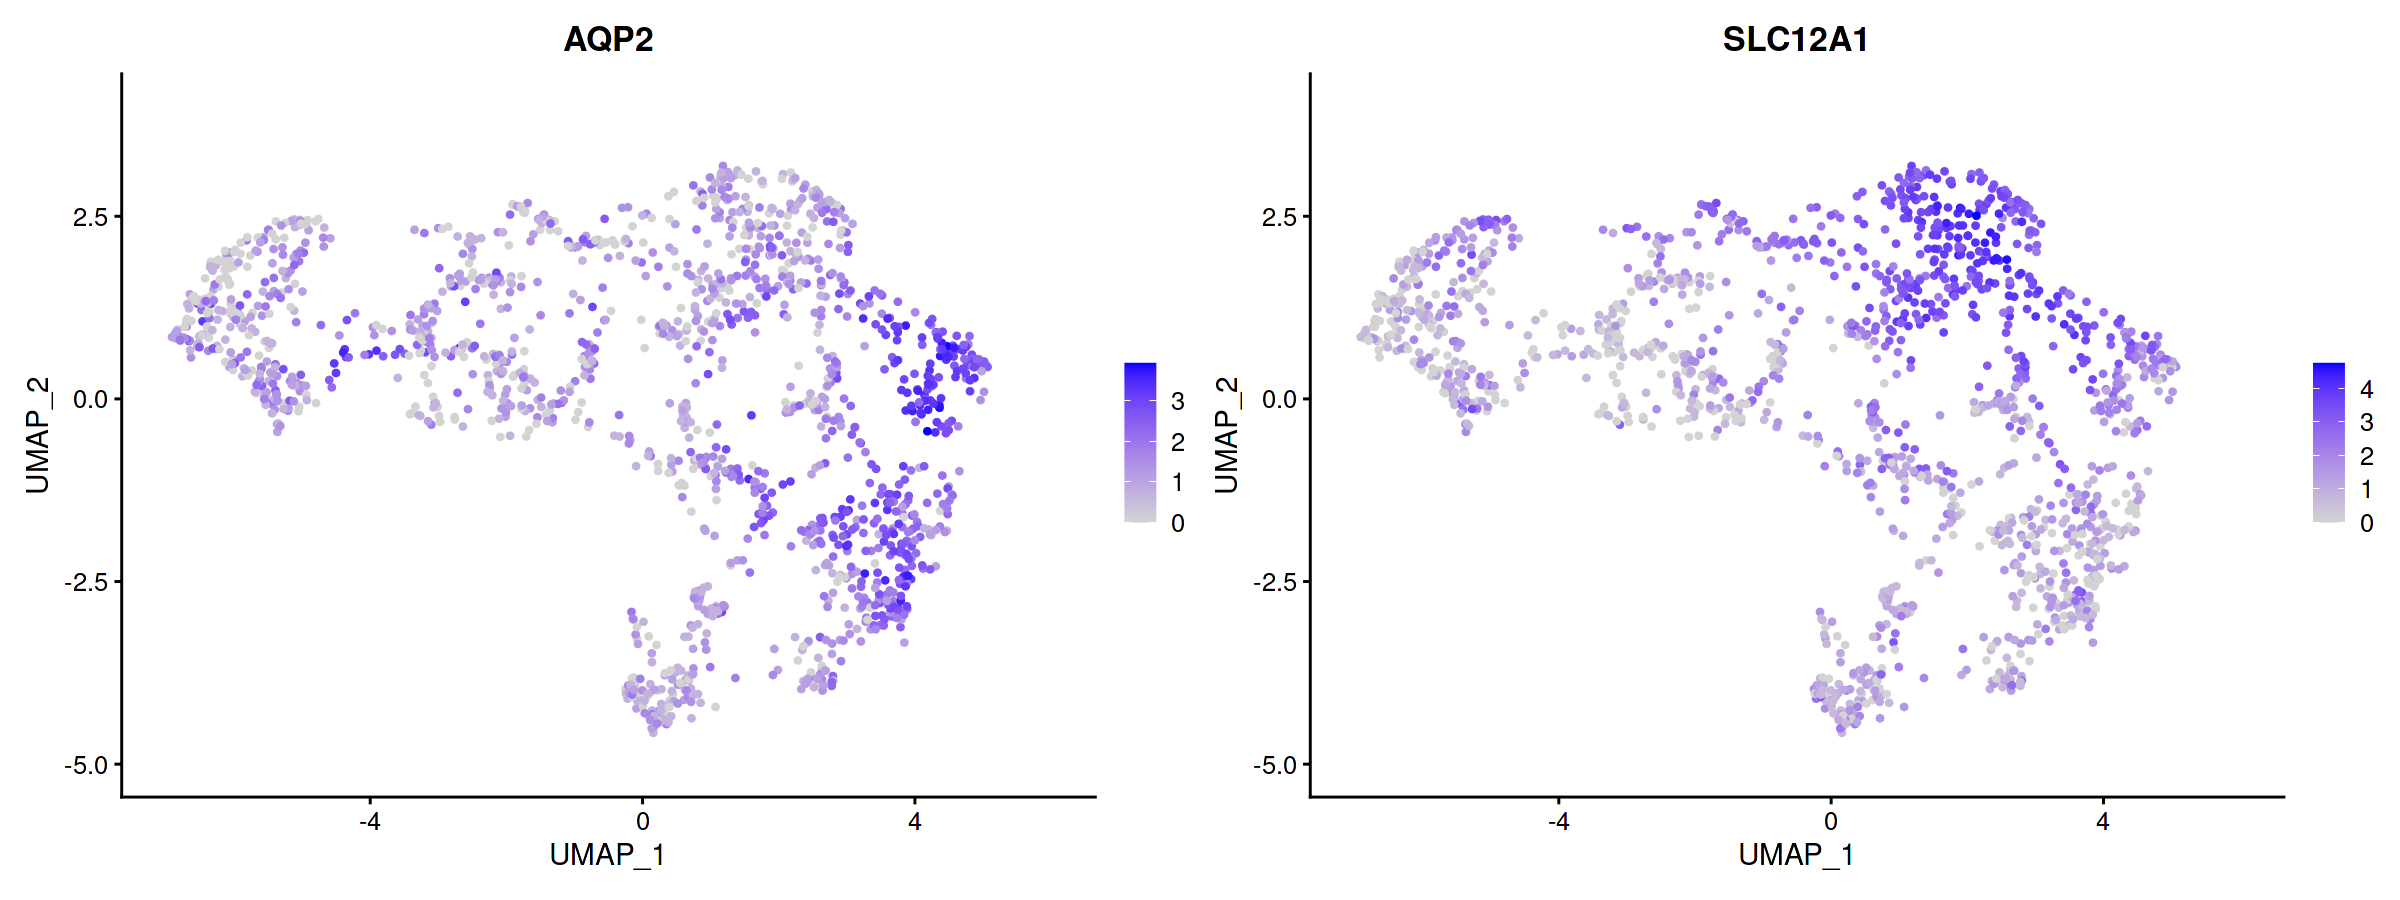

In [19]:
options(repr.plot.width = 16, repr.plot.height = 6, repr.plot.res = 150)
feature_list = c("AQP2", "SLC12A1")
p = FeaturePlot(dkd1_tubules, feature = feature_list)

p

In [20]:
for (feature_single in feature_list){
    p <- FeaturePlot(dkd1_tubules, feature = feature_single) + 
#    guides(fill = guide_legend(override.aes = list(size=6), title="nCount_Spatial") ) +
    custom_theme + 
    empty_theme
    
    ggsave(p, filename = file.path(plots_path_supp, paste0("FeaturePlot_tubules_",feature_single,".png")), width = 8, height = 6, units = "in", dpi = 300)
    ggsave(p, filename = file.path(plots_path_supp, paste0("FeaturePlot_tubules_",feature_single,".pdf")), width = 8, height = 6, units = "in", dpi = 300)
    ggsave(p, filename = file.path(plots_path_supp, paste0("FeaturePlot_tubules_",feature_single,".svg")), width = 8, height = 6, units = "in", dpi = 300)
 
}

### Step 4. Generate DotPlot

In [21]:
Idents(dkd1_tubules) = factor(dkd1_tubules$Tubules, levels = rev(tubules_cluster))

In [22]:
dkd1_tubules
table(dkd1_tubules$Tubules)

An object of class Seurat 
36083 features across 1639 samples within 2 assays 
Active assay: SCT (17998 features, 3000 variable features)
 1 other assay present: Spatial
 2 dimensional reductions calculated: pca, umap
 1 image present: slice1


    PT  Inj-T     LH     CD Cast-T 
   295    345    253    396    350 

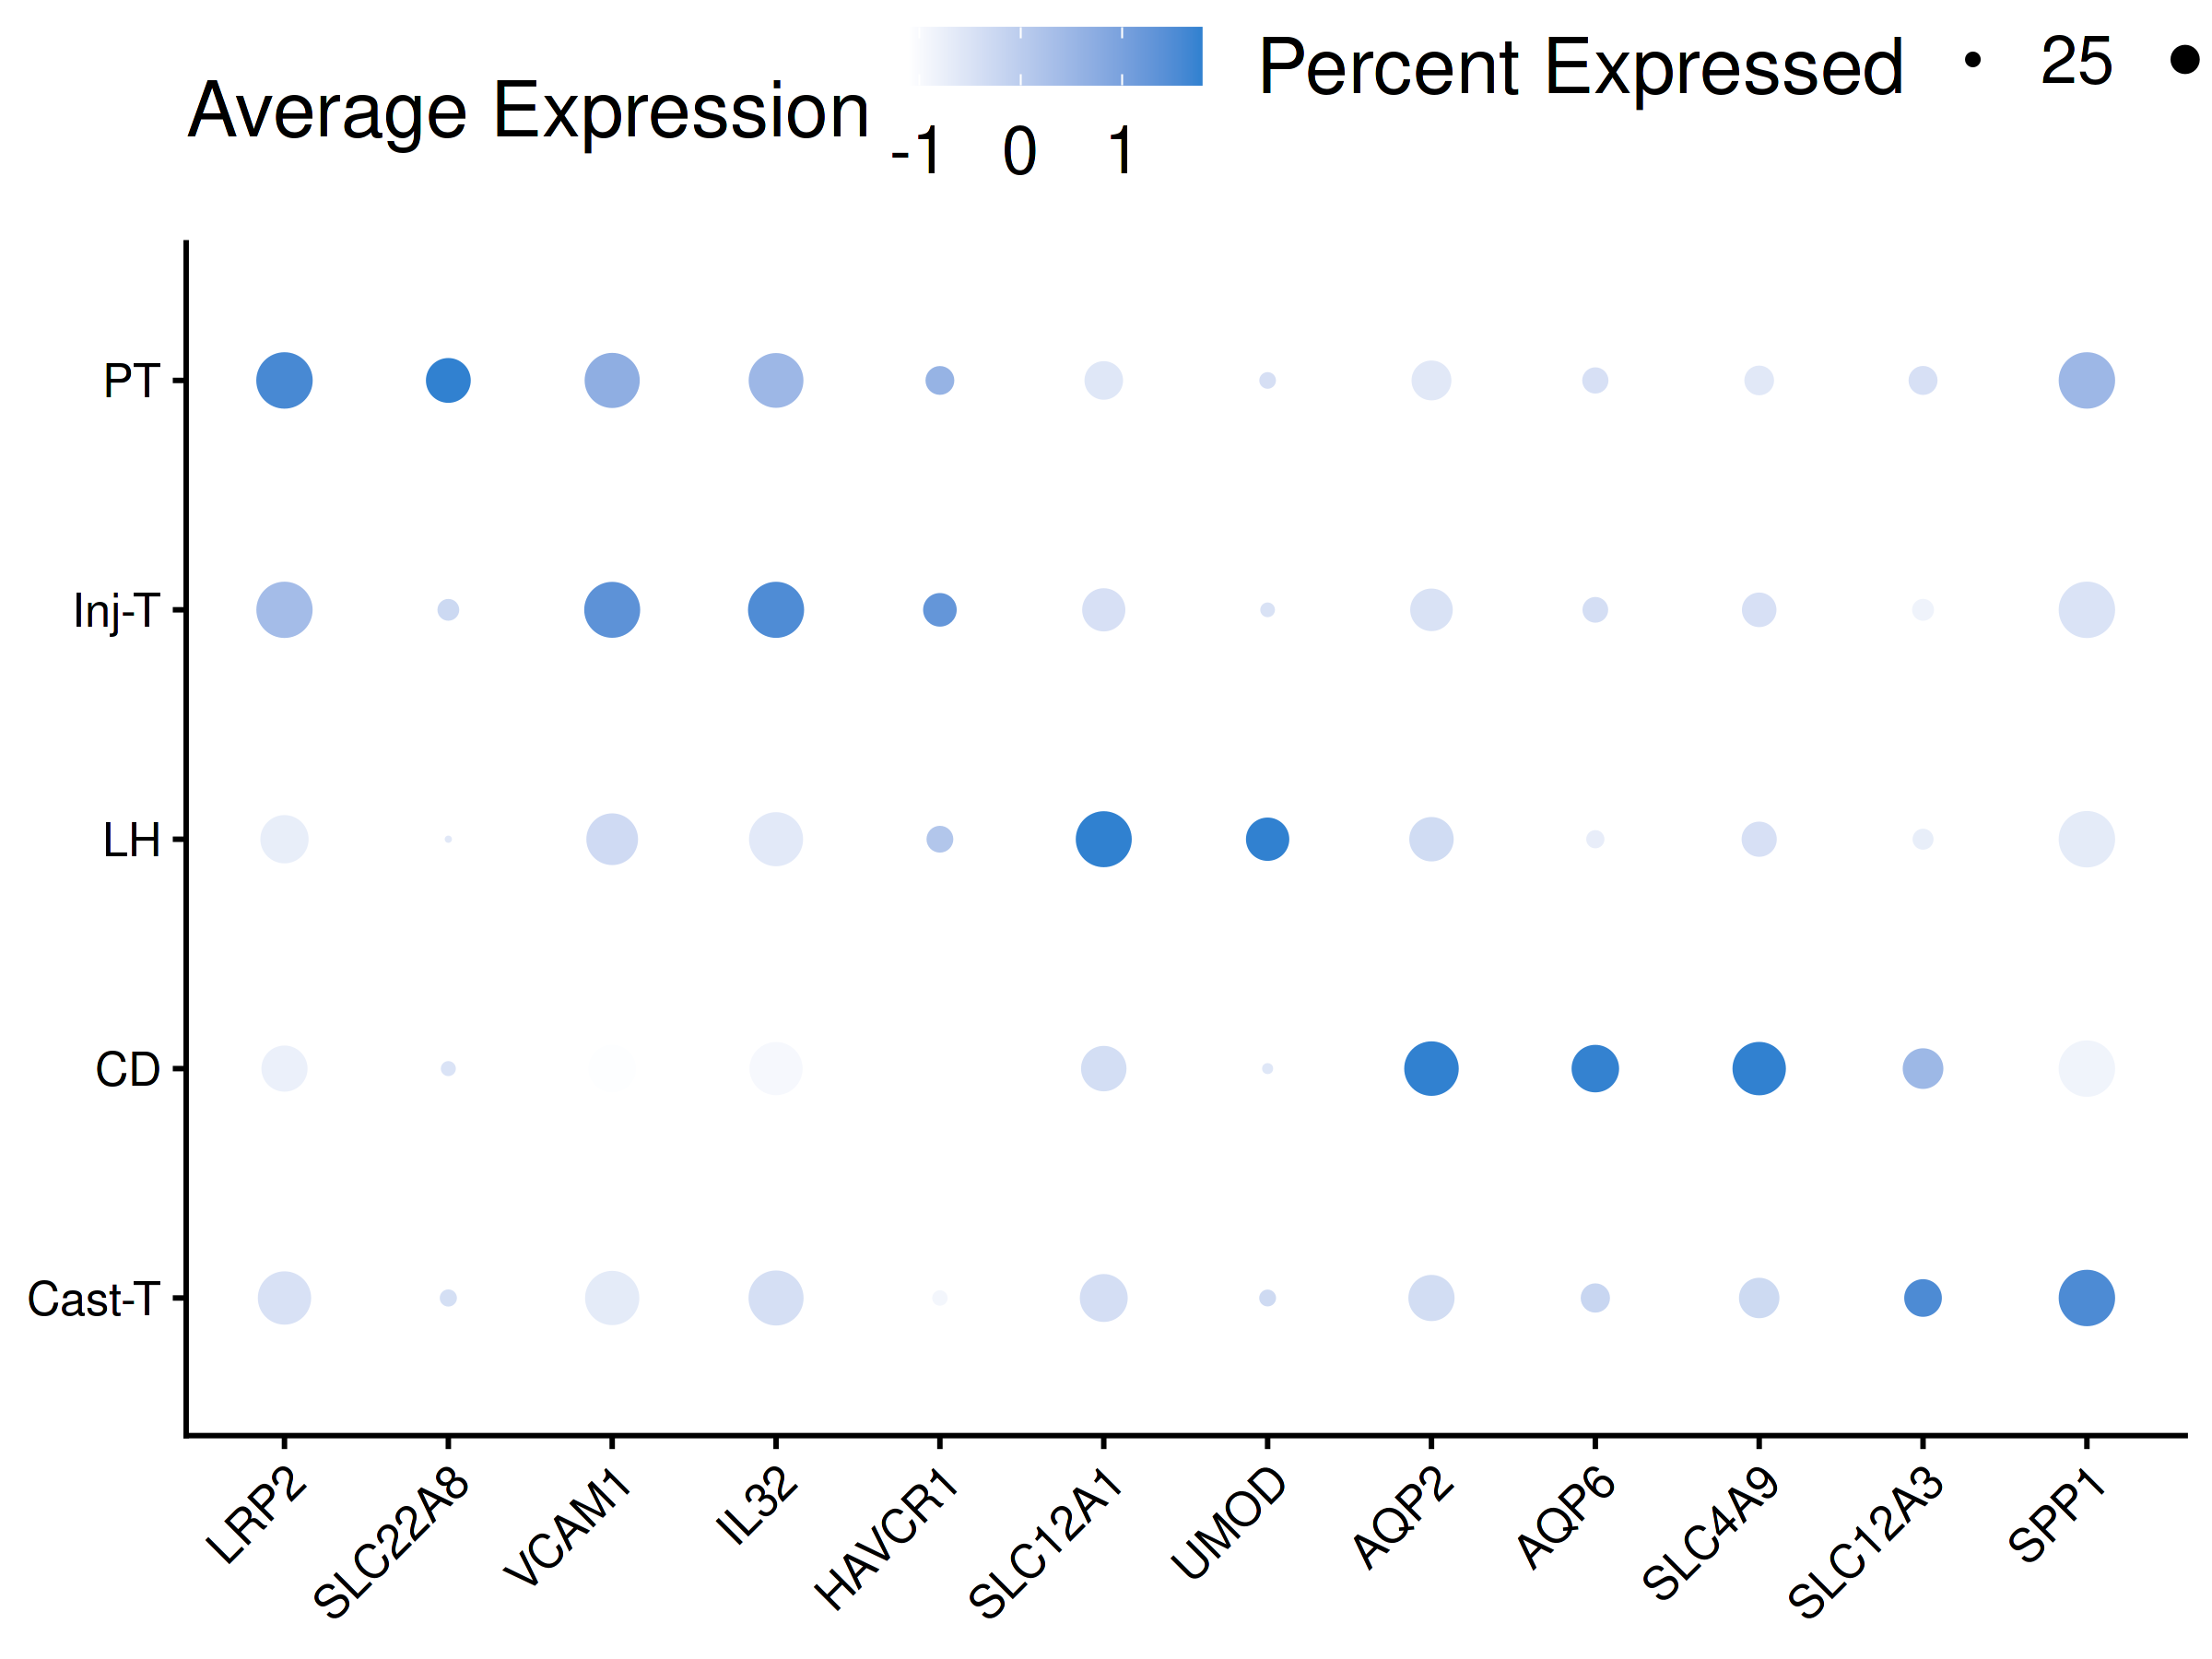

In [23]:
options(repr.plot.width = 8, repr.plot.height = 6, repr.plot.res = 300)

feature_genes <- c("LRP2", "SLC22A8",
                   "VCAM1", "IL32", "HAVCR1",
                   "SLC12A1", "UMOD",
                   "AQP2", "AQP6", "SLC4A9",  
                   "SLC12A3", "SPP1"
                  )
p = DotPlot(object = dkd1_tubules, features = feature_genes,
           cols = c("white", "#3081D0")) + 
theme(axis.text.x = element_text(angle = 45, hjust = 1)) +
     custom_theme + 
    theme(axis.title.x=element_blank(),
         axis.title.y=element_blank(),
         legend.position="top")
p

ggsave(p, filename = file.path(plots_path_supp, "DotPlot_tubules_Morph_based.png"), width = 8, height = 6, units = "in", dpi = 300)
ggsave(p, filename = file.path(plots_path_supp, "DotPlot_tubules_Morph_based.pdf"), width = 8, height = 6, units = "in", dpi = 300)


### Step 5. Pseudotime analysis using Monocle 3

#### Step 5.1. Convert toas.cell_data_set

In [24]:
suppressMessages(library(monocle3))
suppressMessages(library(SeuratWrappers))
suppressMessages(library(patchwork))
suppressMessages(library(magrittr))

Warning message:
“multiple methods tables found for ‘aperm’”
Warning message:
“replacing previous import ‘BiocGenerics::aperm’ by ‘DelayedArray::aperm’ when loading ‘SummarizedExperiment’”


In [25]:
dkd1_tubules = readRDS("../../processed_data/version_1/dkd1_tubules_umap.RDS")

In [26]:
cds <- as.cell_data_set(dkd1_tubules)

Warning message:
“Monocle 3 trajectories require cluster partitions, which Seurat does not calculate. Please run 'cluster_cells' on your cell_data_set object”


In [27]:
cds

class: cell_data_set 
dim: 17998 1639 
metadata(0):
assays(2): counts logcounts
rownames(17998): SAMD11 NOC2L ... MT-ND6 MT-CYB
rowData names(0):
colnames(1639): AACAGGTTATTGCACC-1 AACAGGTTCACCGAAG-1 ...
  TGTTGGAACGAGGTCA-1 TGTTGGATGGACTTCT-1
colData names(11): orig.ident nCount_Spatial ... ident Size_Factor
reducedDimNames(2): PCA UMAP
mainExpName: SCT
altExpNames(0):

#### Step 5.2. Create rowData for cds as it's missing after conversion

In [28]:
rowData_df = data.frame("gene_short_name" = names(cds@rowRanges))
rownames(rowData_df) = rowData_df$gene_short_name

rowData(cds) = rowData_df

#### Step 5.3. Run cluster_cells

In [29]:
cds <- cluster_cells(cds, resolution=0.05)

In [30]:
cds <- learn_graph(cds,use_partition = TRUE, verbose = FALSE, learn_graph_control=list(minimal_branch_len=20))

  |======================================================================| 100%


Warning message in igraph::graph.dfs(stree_ori, root = root_cell, neimode = "all", :
“Argument `neimode' is deprecated; use `mode' instead”


#### Step 5.4. Visualize pseudotime trajectory

In [31]:
p1 <- plot_cells(cds, 
                 label_groups_by_cluster = F, 
                 label_leaves = FALSE, 
                 label_branch_points = FALSE,
                 label_roots = F,
                 cell_size = 1, 
                 trajectory_graph_color = "navy",   
                 trajectory_graph_segment_size = 0.5)
p1 = p1 + custom_theme + empty_theme+
ggtitle("Monocle3 Pseudotime Analysis")

Warning message:
“`select_()` was deprecated in dplyr 0.7.0.
ℹ Please use `select()` instead.
ℹ The deprecated feature was likely used in the monocle3 package.
  Please report the issue to the authors.”


In [32]:
cds <- order_cells(cds, root_cells = colnames(cds[,clusters(cds) == 2]))

In [33]:
p2 <- plot_cells(cds, 
                 color_cells_by = "pseudotime", 
                 label_cell_groups = FALSE, 
                 label_leaves = FALSE, 
                 label_roots = F ,
                 label_branch_points = TRUE,
                 cell_size = 1, 
                 trajectory_graph_color = "red",   
                 trajectory_graph_segment_size = 1)

p2 = p2 + custom_theme + empty_theme+
ggtitle("Monocle3 Pseudotime Analysis")



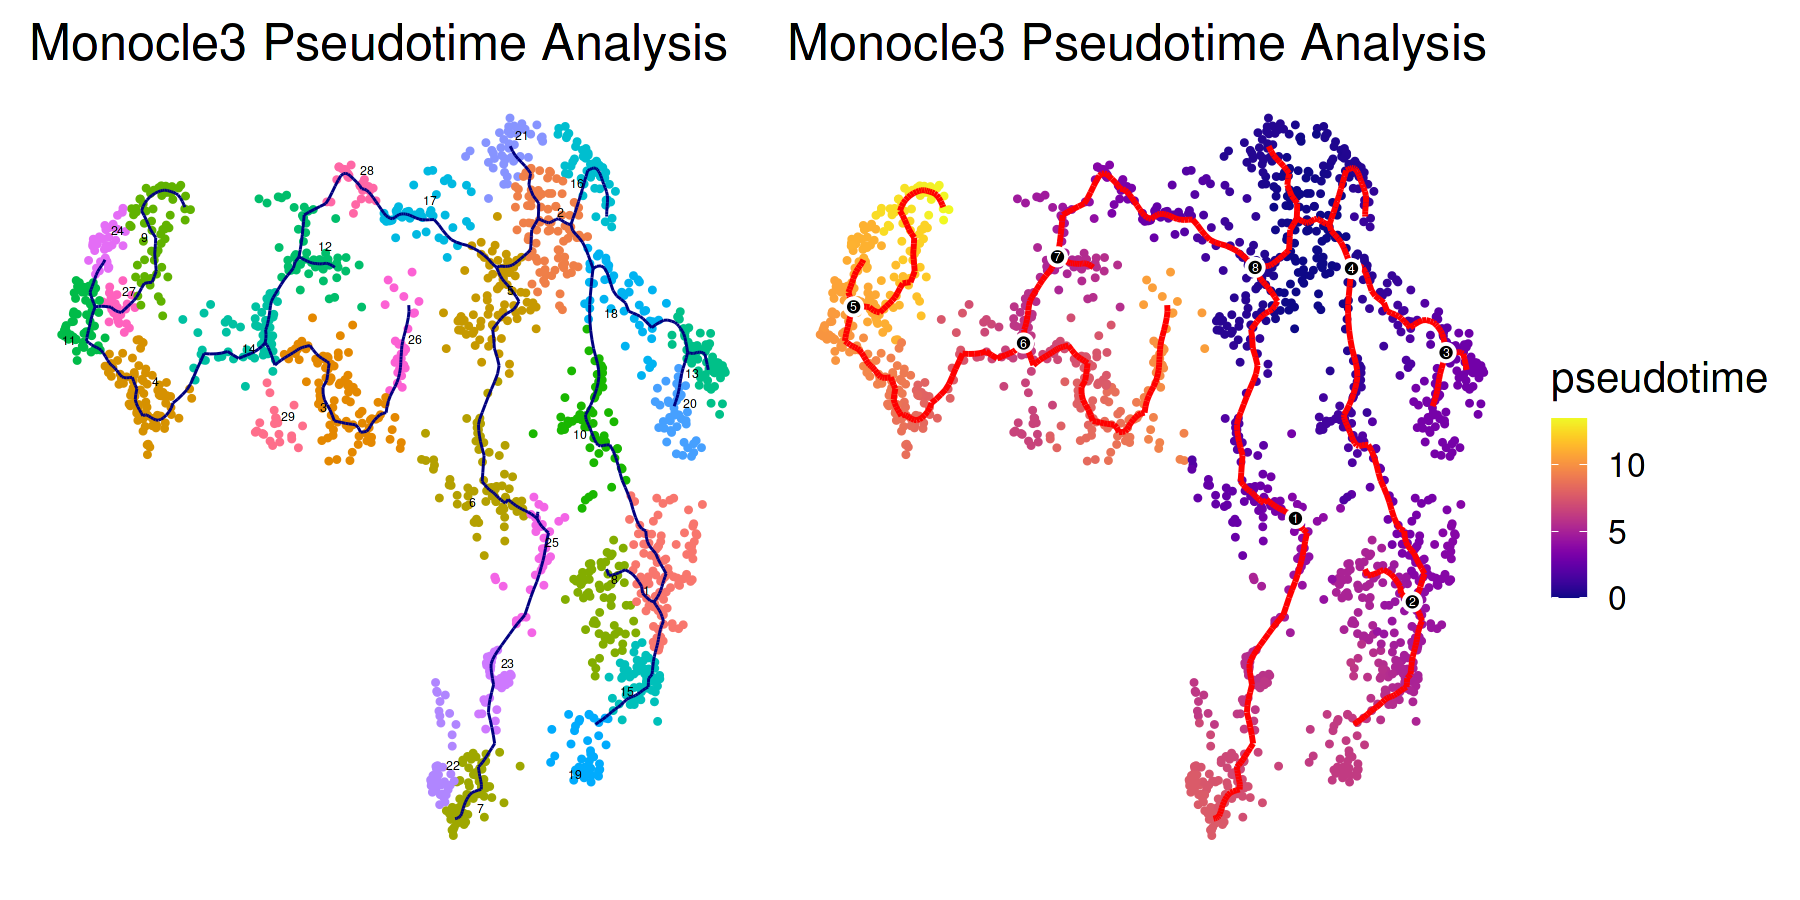

In [34]:
options(repr.plot.width = 12, repr.plot.height = 6, repr.plot.res = 150)
p1 | p2

ggsave(file.path(plots_path_main, "monocle3_tubules.png"), plot = p2, width = 8, height = 6, units = "in", dpi = 300)
ggsave(file.path(plots_path_main, "monocle3_tubules.pdf"), plot = p2, width = 8, height = 6, units = "in", dpi = 300)
ggsave(file.path(plots_path_main, "monocle3_tubules.svg"), plot = p2, width = 8, height = 6, units = "in", dpi = 300)

### Step 6. DEG volcano plot between PT and Inj-T

In [35]:
PT.vs.InjT.markers <- FindMarkers(dkd1_tubules, ident.1 = c("Inj-T"), ident.2 = c("PT"), min.pct = 0.1, return.thresh = 0.05)

In [36]:
deg = PT.vs.InjT.markers

keyvals <- ifelse(
    deg$avg_log2FC > 0 & deg$p_val_adj < 0.05, as.character(color_palette_tubules["Inj-T"]),
      ifelse(deg$avg_log2FC < 0 & deg$p_val_adj < 0.05, as.character(color_palette_tubules["PT"]),
        '#ADB6B6'))
  keyvals[is.na(keyvals)] <- '#ADB6B6'
  names(keyvals)[keyvals == as.character(color_palette_tubules["Inj-T"])] <- 'Inj-T'
  names(keyvals)[keyvals == as.character(color_palette_tubules["PT"])] <- 'PT'
  names(keyvals)[keyvals == '#ADB6B6'] <- 'p.adj>=0.05'

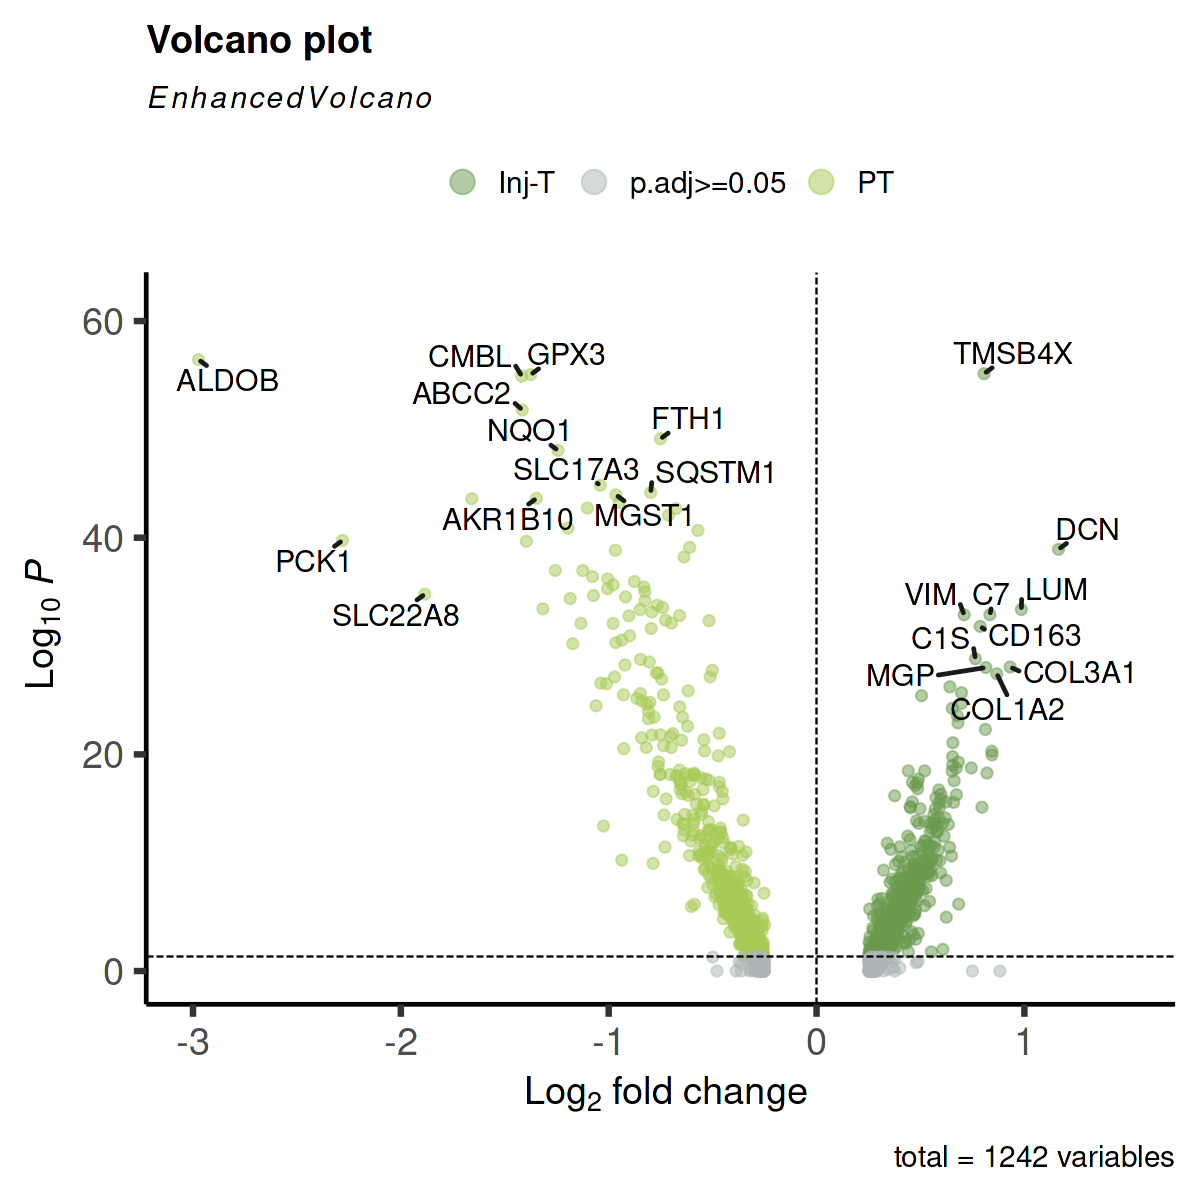

In [37]:
options(repr.plot.width = 8, repr.plot.height = 8, repr.plot.res = 150)

my_select = c(rownames(deg)[deg$avg_log2FC > 0][1:10], rownames(deg)[deg$avg_log2FC < 0][1:10], "PCK1", "SLC22A8")

p = EnhancedVolcano(deg,
                    rownames(deg),
                    selectLab = my_select,
                    drawConnectors = TRUE,
                    arrowheads = FALSE,
                    widthConnectors = 0.8,
                    x ="avg_log2FC",
                    y ="p_val_adj",
                    xlim = c(-3, 1.5),
                    pCutoff = 0.05,
                    FCcutoff = 0,      #  to not show the X axes,
                    gridlines.major = FALSE,
                    gridlines.minor = FALSE,
                    colCustom = keyvals
#                     col=c(), '#ADB6B6', as.character(color_palette_tubules["Inj-T"]), as.character(color_palette_tubules["PT"])),
)
p = p + custom_theme
p

ggsave(file.path(plots_path_main, "VolcanoPlot_FindMarkers_Inj_vs_PT.png"), plot = p, width = 8, height = 8, units = "in", dpi = 300)
ggsave(file.path(plots_path_main, "VolcanoPlot_FindMarkers_Inj_vs_PT.pdf"), plot = p, width = 8, height = 8, units = "in", dpi = 300)
ggsave(file.path(plots_path_main, "VolcanoPlot_FindMarkers_Inj_vs_PT.svg"), plot = p, width = 8, height = 8, units = "in", dpi = 300)

### Step 7. DEG ORA analysis between Inj-T and PT

In [38]:
suppressMessages(library(gplots))
suppressMessages(library(clusterProfiler))
suppressMessages(library(ComplexHeatmap))
suppressMessages(library(org.Hs.eg.db))
suppressMessages(library(scales))

In [39]:
gene_list = rownames(deg)[deg$avg_log2FC > 0 & deg$p_val < 0.001]
# gene_list = rownames(deg)
ids <- bitr(gene_list, fromType = 'SYMBOL', toType = c('SYMBOL', 'ENTREZID'), OrgDb = 'org.Hs.eg.db')
ids = ids$ENTREZID
length(ids)

'select()' returned 1:1 mapping between keys and columns

Warning message in bitr(gene_list, fromType = "SYMBOL", toType = c("SYMBOL", "ENTREZID"), :
“0.93% of input gene IDs are fail to map...”


[1] 638

In [40]:
# Enrichment analysis with enrichGO Biological Process (BP)
ego <- enrichGO(gene         = ids,
                 OrgDb         = org.Hs.eg.db,
                 keyType       = 'ENTREZID',
                 ont           = "BP",
                 pAdjustMethod = "BH",
                 pvalueCutoff  = 0.01,
                 qvalueCutoff  = 0.05)

Scale for y is already present.
Adding another scale for y, which will replace the existing scale.


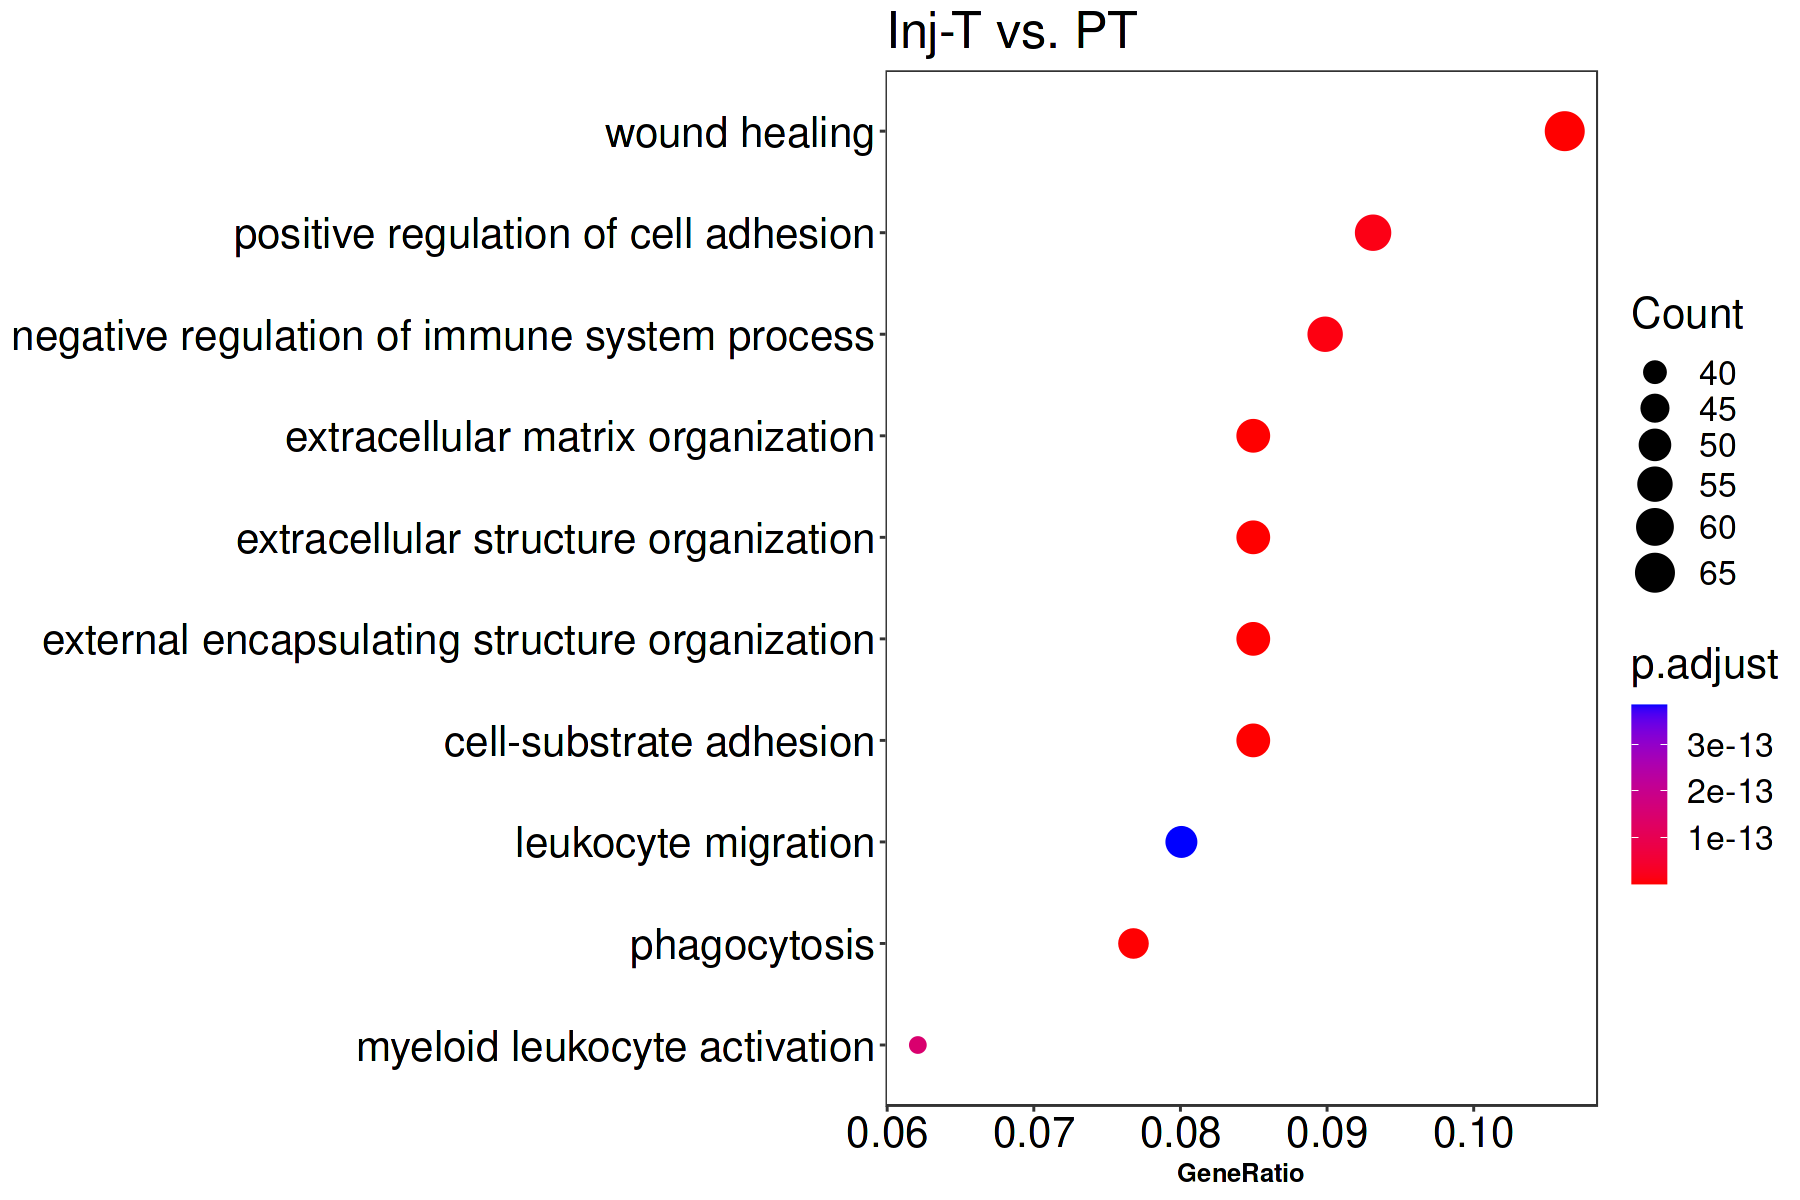

In [41]:
options(repr.plot.width = 12, repr.plot.height = 8, repr.plot.res = 150)
# Plot and visualise the data
p = dotplot(ego)
# adjust the size of y axis labels

p = p + scale_y_discrete(labels = wrap_format(100))
p = p + custom_theme +
theme(axis.title.x = element_text(face="bold", size = 20), 
      axis.text.x=element_text(size=20),
      axis.text.y=element_text(size=20),
      panel.grid.major = element_blank(),
    panel.grid.minor = element_blank()
) + ggtitle("Inj-T vs. PT")
p

ggsave(file.path(plots_path_main, "ORA_DotPlot_tubules_InjT_vs_PT.png"), plot = p, width = 10, height = 8, units = "in", dpi = 300)
ggsave(file.path(plots_path_main, "ORA_DotPlot_tubules_InjT_vs_PT.pdf"), plot = p, width = 10, height = 8, units = "in", dpi = 300)
ggsave(file.path(plots_path_main, "ORA_DotPlot_tubules_InjT_vs_PT.svg"), plot = p, width = 10, height = 8, units = "in", dpi = 300)

In [42]:
sessionInfo()

R version 4.2.2 (2022-10-31)
Platform: x86_64-pc-linux-gnu (64-bit)
Running under: Ubuntu 20.04.2 LTS

Matrix products: default
BLAS:   /usr/lib/x86_64-linux-gnu/blas/libblas.so.3.9.0
LAPACK: /usr/lib/x86_64-linux-gnu/lapack/liblapack.so.3.9.0

locale:
 [1] LC_CTYPE=en_US.UTF-8       LC_NUMERIC=C              
 [3] LC_TIME=en_US.UTF-8        LC_COLLATE=en_US.UTF-8    
 [5] LC_MONETARY=en_US.UTF-8    LC_MESSAGES=en_US.UTF-8   
 [7] LC_PAPER=en_US.UTF-8       LC_NAME=C                 
 [9] LC_ADDRESS=C               LC_TELEPHONE=C            
[11] LC_MEASUREMENT=en_US.UTF-8 LC_IDENTIFICATION=C       

attached base packages:
[1] grid      stats4    stats     graphics  grDevices utils     datasets 
[8] methods   base     

other attached packages:
 [1] scales_1.2.1                org.Hs.eg.db_3.16.0        
 [3] AnnotationDbi_1.60.2        ComplexHeatmap_2.14.0      
 [5] clusterProfiler_4.6.2       gplots_3.1.1               
 [7] magrittr_2.0.3              patchwork_1.1.3            
